In [1]:
# Import / install relevant Python packages
import numpy as np
import pandas as pd  
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
window = 48
# I will continue with 2 ( since in paper it is used average for 1990 - 2020 - 3157 ) 
# and with using 2 I get 3284 ( for 1 is 2878)
max_number_of_nulls_in_observation = 2

In [3]:
feature_names_list = ['mom1m','absacc','acc','aeavol','age','agr','baspread',
'beta','betasq','bm','bm_ia','cash','cashdebt','cashpr','cfp','cfp_ia',
'chatoia','chcsho','chempia','chinv','chmom','chpmia','chtx','cinvest',
'convind','currat','depr','divi','divo','dolvol','dy','ear','egr','ep',
'gma','herf','hire','idiovol','ill','indmom','invest','lev','lgr','maxret',
'ms','mve_ia','mvel1','nincr','operprof','pchcapx_ia','pchcurrat','pchdepr',
'pchgm_pchsale','pchquick','pchsale_pchrect','pctacc','pricedelay',
'ps','quick','rd','retvol','roaq','roeq','roic','rsup','salecash',
'salerec','securedind','sgr','sin','sp','std_dolvol','std_turn',
'tang','tb','turn','zerotrade']

In [4]:
mom_names_list = ["mom1m","mom2m","mom3m","mom4m","mom5m","mom6m","mom7m","mom8m","mom9m","mom10m","mom11m","mom12m",
                "mom13m","mom14m","mom15m","mom16m","mom17m","mom18m","mom19m","mom20m","mom21m","mom22m","mom23m","mom24m",
                "mom25m","mom26m","mom27m","mom28m","mom29m","mom30m","mom31m","mom32m","mom33m","mom34m","mom35m","mom36m",
                "mom37m","mom38m","mom39m","mom40m","mom41m","mom42m","mom43m","mom44m","mom45m","mom46m","mom47m","mom48m"]


In [5]:

df_radni = pd.read_csv('D:/USB Drive/Data/DachengXiu/df_radni.csv')

<AxesSubplot: ylabel='Frequency'>

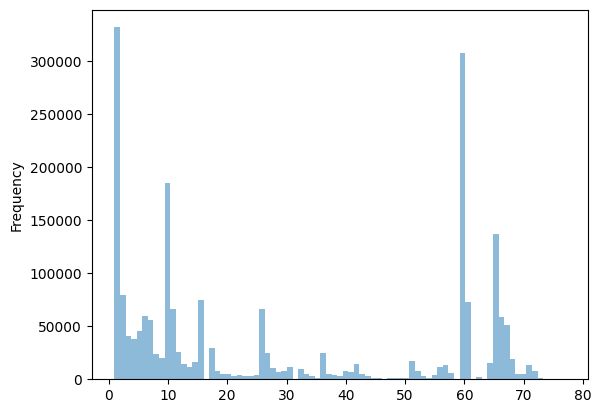

In [6]:
#how many nuuls per parameter - in dataset
temp = df_radni.isnull().sum(axis = 1).sort_values()
temp[temp > 0].plot.hist(bins=81, alpha=0.5)

<AxesSubplot: ylabel='Frequency'>

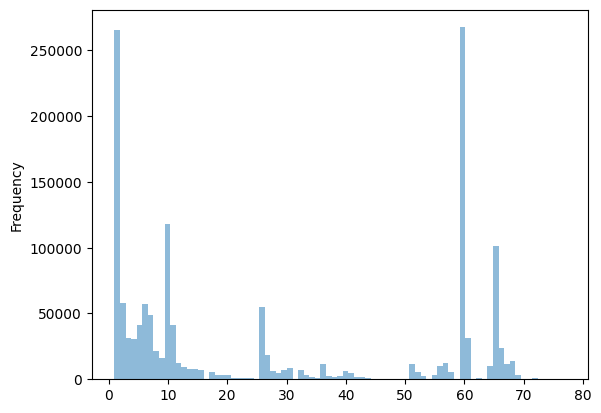

In [7]:
#how many nuuls per parameter - after 1990
temp = df_radni[(df_radni['DATE'] >= 19891231 )].isnull().sum(axis = 1).sort_values()
temp[temp > 0].plot.hist(bins=81, alpha=0.5)

In [8]:
def how_many_companies(df_window):
    #Last date
    last_date = sorted(df_window['DATE'].unique())[-1]
    #unique companies in window
    unique_companies = df_window['permno'].unique()
    list_of_companies_with_null_mom1m = []
    for x in unique_companies:
        #df for for all observatins for one company - should be 48 - if it less all shoud be droped
        df_window_for_company = df_window[df_window['permno'] == x]
        #length od window should be 48
        length_of_window = len(df_window_for_company)
        if (length_of_window == window):
            #checking number of Null in mom1m in observations - max 48
            number_of_null = df_window_for_company['mom1m'].isnull().sum()
            if (number_of_null == 0):
                #umber of nulls - we check if there is more then max_number_of_nulls_in_observation of features on last date
                number_of_nulls_features = df_window_for_company[df_window_for_company["DATE"] == last_date].isnull().sum(axis = 1).mean()
                if not (number_of_nulls_features <= max_number_of_nulls_in_observation):
                    list_of_companies_with_null_mom1m.append(x)
            else:
                list_of_companies_with_null_mom1m.append(x)            
        else:
            list_of_companies_with_null_mom1m.append(x)
    #drop observations of companies with more then max allowed number of null-s in features or withh less then 48 observations or with null in 48 obs of mom1
    df_window = df_window[~df_window.permno.isin(list_of_companies_with_null_mom1m)]
    return len(df_window['permno'].unique())

In [9]:
#checking number of companies after 1990
df_radni_small = df_radni[(df_radni['DATE'] > 19851231) & (df_radni['DATE'] < 20210101)]

In [10]:
#go through list of dates
results = []
dates = sorted(df_radni_small['DATE'].unique())
for date in range(window-1,len(dates)):
    print( "dates[i - window]" , dates[date - window+1]," dates[i] " , dates[date])
    df_window_working = df_radni_small[(df_radni_small['DATE'] >= dates[date - window+1] ) & (df_radni_small['DATE']  <= dates[date])]
    results.append(how_many_companies(df_window_working))


dates[i - window] 19860131  dates[i]  19891229
dates[i - window] 19860228  dates[i]  19900131
dates[i - window] 19860331  dates[i]  19900228
dates[i - window] 19860430  dates[i]  19900330
dates[i - window] 19860530  dates[i]  19900430
dates[i - window] 19860630  dates[i]  19900531
dates[i - window] 19860731  dates[i]  19900629
dates[i - window] 19860829  dates[i]  19900731
dates[i - window] 19860930  dates[i]  19900831
dates[i - window] 19861031  dates[i]  19900928
dates[i - window] 19861128  dates[i]  19901031
dates[i - window] 19861231  dates[i]  19901130
dates[i - window] 19870130  dates[i]  19901231
dates[i - window] 19870227  dates[i]  19910131
dates[i - window] 19870331  dates[i]  19910228
dates[i - window] 19870430  dates[i]  19910328
dates[i - window] 19870529  dates[i]  19910430
dates[i - window] 19870630  dates[i]  19910531
dates[i - window] 19870731  dates[i]  19910628
dates[i - window] 19870831  dates[i]  19910731
dates[i - window] 19870930  dates[i]  19910830
dates[i - win

In [11]:
from datetime import date


def int2date(argdate: int) -> date:
    """
    If you have date as an integer, use this method to obtain a datetime.date object.

    Parameters
    ----------
    argdate : int
      Date as a regular integer value (example: 20160618)

    Returns
    -------
    dateandtime.date
      A date object which corresponds to the given value `argdate`.
    """

    dates = []

    for i in argdate:
      year = int(i / 10000)
      month = int((i % 10000) / 100)
      day = int(i % 100)
      dates.append(date(year, month, day))

    return dates

In [12]:
df_results = pd.DataFrame(np.column_stack([dates[window-1:(window + len(results))], results]), 
                               columns=['Dates', 'Number_of_companies'])
df_results_dates = pd.DataFrame(np.column_stack([int2date(dates[(window-1):(window + len(results))]), results]), 
                               columns=['Dates', 'Number_of_companies'])


<AxesSubplot: xlabel='Dates'>

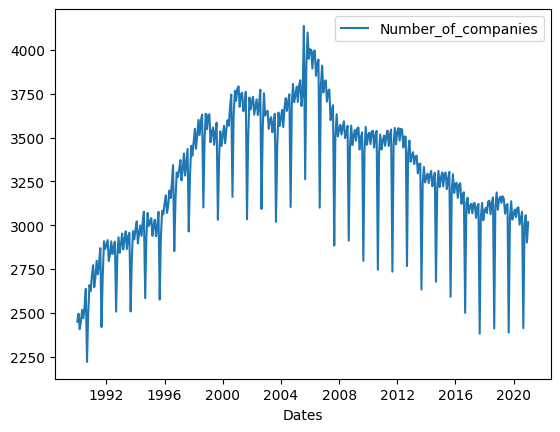

In [13]:
df_results_dates.plot(x="Dates", y="Number_of_companies")

We can see that every year on 08.31. there are more missing values then other months.

In [257]:
df_results[(df_results['Dates']) > 19891231 & (df_results['Dates'] < 20210101)]['Number_of_companies'].mean()

3284.3351206434318

In [14]:
def clean_df_of_companies_with_non_adequate_observations(df_for_clean):
    counter_less_48 = 0
    counter_some_mom1m_null = 0
    counter_more_nulls_in_features_than_alowed = 0
    #Last date
    last_date = sorted(df_for_clean['DATE'].unique())[-1]
    #unique companies in window
    unique_companies = df_for_clean['permno'].unique()
    list_of_companies_with_null_mom1m = []
    for x in unique_companies:
        #df for for all observatins for one company - should be 48 - if it less all shoud be droped
        df_for_clean_for_company = df_for_clean[df_for_clean['permno'] == x]
        #length od window should be 48
        length_of_window = len(df_for_clean_for_company)
        if (length_of_window == window):
            #checking number of Null in mom1ms in observations - max 48
            number_of_null = df_for_clean_for_company['mom1m'].isnull().sum()
            if (number_of_null == 0):
                #umber of nulls - we check if there is more then max_number_of_nulls_in_observation of features on last date
                number_of_nulls_features = df_for_clean_for_company[df_for_clean_for_company["DATE"] == last_date].isnull().sum(axis = 1).mean()
                if not (number_of_nulls_features <= max_number_of_nulls_in_observation):
                    list_of_companies_with_null_mom1m.append(x)
                    counter_more_nulls_in_features_than_alowed = counter_more_nulls_in_features_than_alowed +1
            else:
                list_of_companies_with_null_mom1m.append(x)
                counter_some_mom1m_null = counter_some_mom1m_null +1            
        else:
            list_of_companies_with_null_mom1m.append(x)
            counter_less_48 = counter_less_48 +1
    #drop observations of companies with more then max allowed number of null-s in features or withh less then 48 observations or with null in 48 obs of mom1
    df_for_clean = df_for_clean[~df_for_clean.permno.isin(list_of_companies_with_null_mom1m)]
    print("Length od window less then 48 ", counter_less_48," Number of Null in mom1ms " ,counter_some_mom1m_null , "Number of nulls in features more than alowed ", counter_more_nulls_in_features_than_alowed )
    return df_for_clean

In [16]:
df_moms = pd.DataFrame(columns=mom_names_list[1:])
df_empty_copy_of_radni = pd.DataFrame(data=None, columns=df_radni.columns, index=df_radni.index)
df_with_moms = pd.concat([df_empty_copy_of_radni, df_moms],axis=1 ).iloc[0:0]


In [19]:
def add_moms_features_for_last_date_and_drop_observations_of_other_dates(df_for_adding_moms):
    #adding empty moms columns
    df_for_adding_moms = pd.concat([df_for_adding_moms, df_moms],axis=1 )
    #Last date
    last_date = sorted(df_for_adding_moms['DATE'].unique())[-1]
    #go through list of companies
    for company in df_for_adding_moms['permno'].unique():
        #taking mom1m values from 48 rows
        moms_list = df_for_adding_moms[df_for_adding_moms['permno'] == company].sort_values('DATE')
        #detrming index of last date row
        indeks = moms_list[moms_list['DATE']== last_date].index[0]        
        #making list of reverse order since it is from older date to newer
        moms_list = moms_list['mom1m'].iloc[::-1].values.tolist()
        #calculate moms from formula mom1m, mom2m = mom1(shifted 1), ... , momim = ( momi-1m + 1)* ( mom1(shifted i-1) + 1) -1 
        for i in range(2,len(moms_list)):
            moms_list[i] = (moms_list[i-1]+1)*(moms_list[i]+1)-1
        # fill values of moms ( from 48 rows ) to columns 
        df_for_adding_moms.loc[indeks,mom_names_list] = moms_list
    #drop all exept last date
    df_for_adding_moms = df_for_adding_moms[df_for_adding_moms['DATE'] == last_date]
    return df_for_adding_moms

In [20]:
#go through list of dates
results = []
dates = sorted(df_radni['DATE'].unique())
for date in range(window-1,len(dates)):
    print( "dates[i - window]" , dates[date - window+1]," dates[i] " , dates[date])
    df_window_working = df_radni[(df_radni['DATE'] >= dates[date - window +1] ) & (df_radni['DATE']  <= dates[date])]
    df_window_cleaned = clean_df_of_companies_with_non_adequate_observations(df_window_working)
    df_window_with_moms = add_moms_features_for_last_date_and_drop_observations_of_other_dates(df_window_cleaned)
    #results.append(how_many_companies(df_window_working))
    df_with_moms = pd.concat([df_with_moms, df_window_with_moms],axis=0 )


dates[i - window] 19760130  dates[i]  19791231
Length od window less then 48  2553  Number of Null in mom1ms  9 Number of nulls in features more than alowed  1856
dates[i - window] 19760227  dates[i]  19800131
Length od window less then 48  2549  Number of Null in mom1ms  12 Number of nulls in features more than alowed  1858
dates[i - window] 19760331  dates[i]  19800229
Length od window less then 48  2589  Number of Null in mom1ms  7 Number of nulls in features more than alowed  1877
dates[i - window] 19760430  dates[i]  19800331
Length od window less then 48  2587  Number of Null in mom1ms  9 Number of nulls in features more than alowed  1866
dates[i - window] 19760528  dates[i]  19800430
Length od window less then 48  2606  Number of Null in mom1ms  11 Number of nulls in features more than alowed  1847
dates[i - window] 19760630  dates[i]  19800530
Length od window less then 48  2610  Number of Null in mom1ms  9 Number of nulls in features more than alowed  1868
dates[i - window] 19

In [21]:
df_with_moms.to_csv('D:/USB Drive/Data/DachengXiu/df_with_moms.csv')

In [5]:
df_with_moms = pd.read_csv('D:/USB Drive/Data/DachengXiu/df_with_moms.csv')

<AxesSubplot: ylabel='Frequency'>

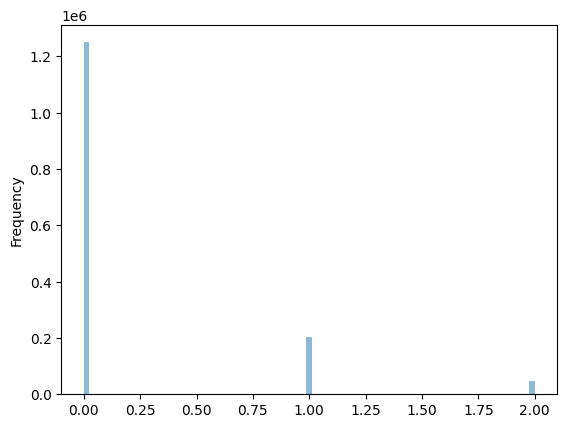

In [91]:
#how many nulls per parameter - in dataset
temp = df_with_moms.isnull().sum(axis = 1).sort_values()
temp[temp >= 0].plot.hist(bins=81, alpha=0.5)

It is small number in entire sample but is more important by date.

In [118]:
#determing number of nulls by features
count_nuns_by_feature=df_with_moms.isnull().astype(int).sum().sort_values(ascending = False)
column_names_with_null_values_features_list = count_nuns_by_feature[count_nuns_by_feature > 0].sort_values(ascending = True).keys().values.tolist()

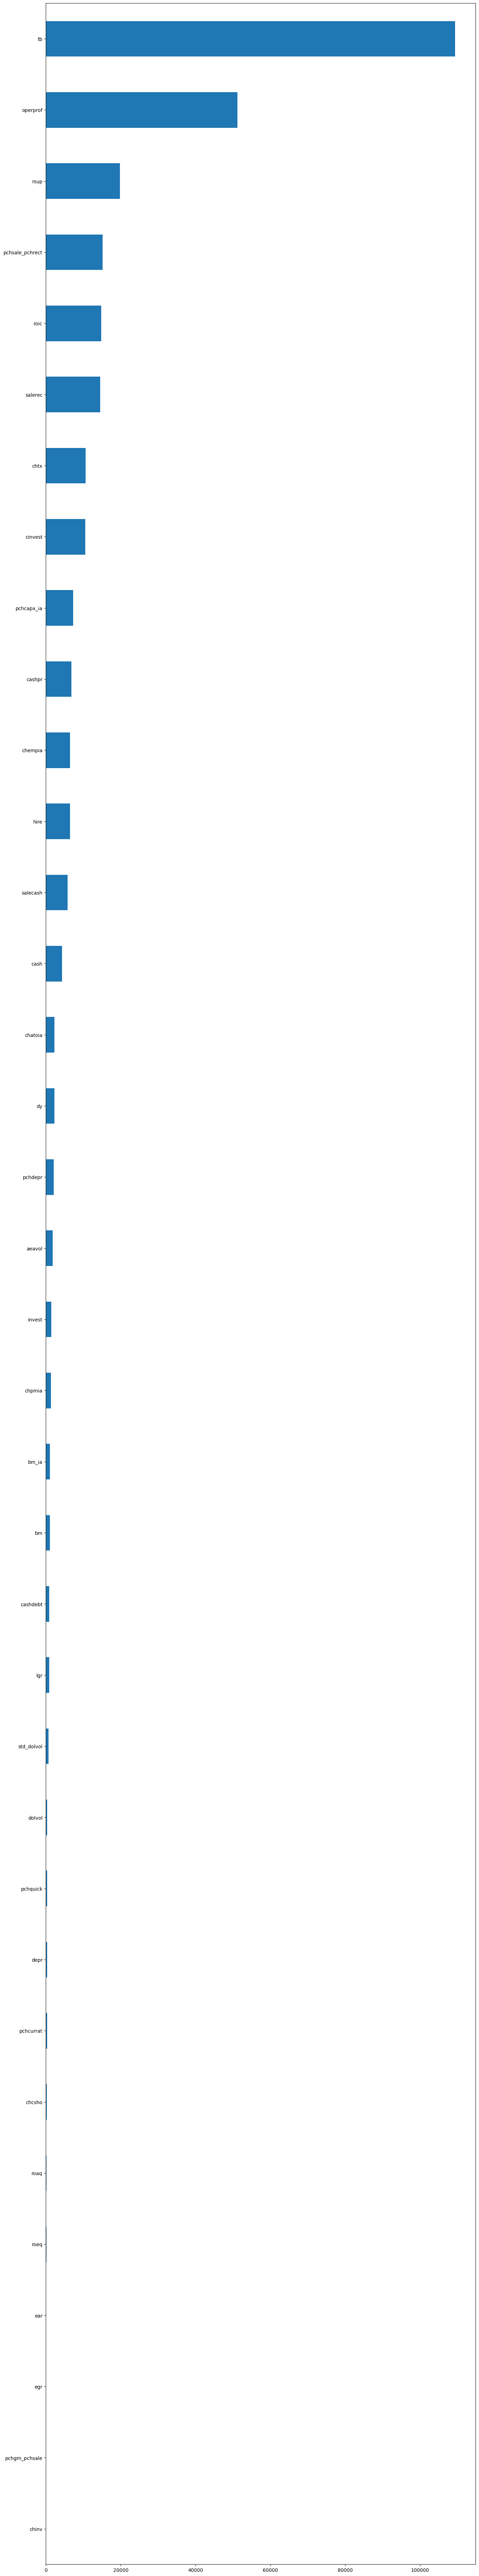

In [93]:
# Create a bar chart to visualize count of nulls by features
plt.figure(figsize=(16, 96))
count_nuns_by_feature[column_names_with_null_values_features_list].plot.barh()
plt.show()

In [94]:
count_nuns_by_feature

tb                 109391
operprof            51191
rsup                19761
pchsale_pchrect     15162
roic                14803
                    ...  
mve_ia                  0
ms                      0
maxret                  0
lev                     0
mom48m                  0
Length: 129, dtype: int64

In [152]:
#calculate nuns in features by date
column_names_with_null_values_features_list.append("DATE")
df_nuuls_of_features_by_date = df_with_moms[column_names_with_null_values_features_list].copy()
df_nuuls_of_features_by_date.set_index('DATE')
column_names_with_null_values_features_list.remove("DATE")
df_nuuls_of_features_by_date[column_names_with_null_values_features_list]=df_nuuls_of_features_by_date[column_names_with_null_values_features_list].isnull().astype(int)
df_nuuls_of_features_by_date = df_nuuls_of_features_by_date.groupby('DATE').sum()
#df_nuuls_of_features_by_date = df_nuuls_of_features_by_date.groupby('DATE').sum().sort_values('tb',ascending=False)

In [168]:
#max missings values in features by single date
df_nuuls_of_features_by_date.max().sort_values(ascending=False).head(10)

tb                 535
chtx               324
bm                 251
bm_ia              251
aeavol             247
operprof           191
rsup               158
roic               136
dolvol              72
pchsale_pchrect     68
dtype: int32

We can see that:
- tb has most missing values. This 535 was on 20051031 and tb was only missing value. tb is not bigger than 16%
- chtx 324 on 19830729.Few months before and after there were some values missing but after there is no missing values for chtx
- bm,bm_ia las few dates are miising 20211231
- aeavol is few months oround 19830531
- operprof is more frequent but is not bigger than 6%

In general tb and operprof are more frequent. Others are just pop up for few months on  the level lower than tb.

<AxesSubplot: xlabel='DATE,DATE'>

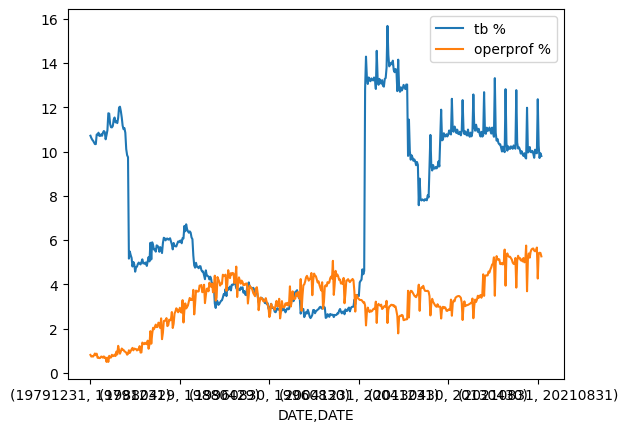

In [219]:
#percentage of tb and operprof missing values by date
df_tb_operprof_by_date = pd.merge(df_nuuls_of_features_by_date[['tb','operprof']],df_with_moms.groupby('DATE').count()['permno'], on=["DATE","DATE"])
df_tb_operprof_by_date["tb %"] = df_tb_operprof_by_date['tb']/df_tb_operprof_by_date['permno']*100
df_tb_operprof_by_date["operprof %"] = df_tb_operprof_by_date['operprof']/df_tb_operprof_by_date['permno']*100
df_tb_operprof_by_date = df_tb_operprof_by_date.drop('tb',axis=1)
df_tb_operprof_by_date = df_tb_operprof_by_date.drop('operprof',axis=1)
df_tb_operprof_by_date = df_tb_operprof_by_date.drop('permno',axis=1)
df_tb_operprof_by_date.plot()

If we inpute median values, it is dificult to estimate if max 16% imputed values, in one of out of 76 ( 76+48=124 ) features would make spurious conclusions.
All analysis should be taken for max_number_of_nulls_in_observation = 1 and max_number_of_nulls_in_observation = 0 ( we are using 2 since it give us same average number of companies as it is stated in paper)

In [274]:
#go through list of dates and fill NA with medion for that date
dates_for_imputation = sorted(df_with_moms['DATE'].unique())
for date in dates_for_imputation:
    df_with_moms[df_with_moms['DATE'] == date] = df_with_moms[df_with_moms['DATE'] == date].mask(df_with_moms[df_with_moms['DATE'] == date].isna(), other=df_with_moms[df_with_moms['DATE'] == date].median(), axis=1)

 date  19791231
 date  19800131
 date  19800229
 date  19800331
 date  19800430
 date  19800530
 date  19800630
 date  19800731
 date  19800829
 date  19800930
 date  19801031
 date  19801128
 date  19801231
 date  19810130
 date  19810227
 date  19810331
 date  19810430
 date  19810529
 date  19810630
 date  19810731
 date  19810831
 date  19810930
 date  19811030
 date  19811130
 date  19811231
 date  19820129
 date  19820226
 date  19820331
 date  19820430
 date  19820528
 date  19820630
 date  19820730
 date  19820831
 date  19820930
 date  19821029
 date  19821130
 date  19821231
 date  19830131
 date  19830228
 date  19830331
 date  19830429
 date  19830531
 date  19830630
 date  19830729
 date  19830831
 date  19830930
 date  19831031
 date  19831130
 date  19831230
 date  19840131
 date  19840229
 date  19840330
 date  19840430
 date  19840531
 date  19840629
 date  19840731
 date  19840831
 date  19840928
 date  19841031
 date  19841130
 date  19841231
 date  19850131
 date  1

In [297]:
df_describe=df_with_moms[feature_names_list].describe(percentiles=[0.01,0.05, 0.5,0.95, 0.99])

In [298]:
(df_describe.T['max']/df_describe.T['95%']).sort_values(ascending=False).head(25)

sin                      inf
divo                     inf
divi                     inf
cinvest          1325.059602
cfp_ia            923.574845
pchcapx_ia        259.973657
mvel1             188.029511
bm_ia             151.861406
ill                79.447149
bm                 65.448977
std_turn           50.567868
chpmia             33.093560
pctacc             27.167539
roeq               18.249832
cfp                18.003261
mve_ia             17.618960
turn               15.990389
pchgm_pchsale      15.139653
quick              14.385559
pricedelay         13.689236
cashpr             13.652818
currat             12.830619
pchdepr            12.261563
sgr                11.645527
egr                11.489480
dtype: float64

In [299]:
df_describe

,mom1m,absacc,acc,aeavol,age,agr,baspread,beta,betasq,bm,...,securedind,sgr,sin,sp,std_dolvol,std_turn,tang,tb,turn,zerotrade
count,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,...,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06,1.502135e+06
mean,1.124730e-02,8.240835e-02,-3.998792e-02,8.752334e-01,1.740374e+01,-1.261192e-01,4.172943e-02,1.098272e+00,1.584552e+00,1.130348e+00,...,4.988440e-01,1.366493e-01,1.032930e-02,1.987911e+00,7.667686e-01,4.858243e+00,5.173284e-01,-1.300372e-01,1.334729e+00,7.908104e-01
std,1.443441e-01,8.902379e-02,1.107578e-01,1.948315e+00,1.151150e+01,3.671040e-01,3.498225e-02,6.136849e-01,1.705101e+00,4.052764e+00,...,4.999988e-01,4.531795e-01,1.011069e-01,2.973773e+00,4.015254e-01,1.367284e+01,1.500034e-01,1.899413e+00,2.161141e+00,2.472515e+00
min,-7.365891e-01,0.000000e+00,-1.016244e+00,-1.000000e+00,2.000000e+00,-5.636087e+00,0.000000e+00,-7.995801e-01,3.887506e-12,-4.753152e+00,...,0.000000e+00,-9.300014e-01,0.000000e+00,-3.594196e+01,0.000000e+00,1.271666e-04,2.010268e-03,-4.078335e+01,0.000000e+00,1.954854e-12
1%,-3.469388e-01,9.256356e-04,-4.407953e-01,-9.278701e-01,4.000000e+00,-1.804419e+00,7.374593e-03,-4.093599e-02,3.290912e-03,-6.647142e-01,...,0.000000e+00,-6.149551e-01,0.000000e+00,1.485629e-02,2.302447e-01,1.333734e-01,1.275199e-01,-4.573624e+00,2.840909e-02,2.153424e-09
5%,-2.036199e-01,4.494054e-03,-2.127252e-01,-7.051634e-01,4.000000e+00,-6.597468e-01,1.212355e-02,2.181738e-01,5.392980e-02,6.366063e-02,...,0.000000e+00,-2.735260e-01,0.000000e+00,1.222260e-01,2.952740e-01,3.719889e-01,2.442615e-01,-1.770112e+00,8.883416e-02,4.686805e-09
50%,3.739459e-03,5.841433e-02,-3.606425e-02,3.558345e-01,1.500000e+01,-6.008998e-02,3.208001e-02,1.034570e+00,1.071377e+00,6.030009e-01,...,0.000000e+00,7.399902e-02,0.000000e+00,1.013906e+00,6.642134e-01,2.276320e+00,5.283418e-01,-8.328340e-02,7.533419e-01,2.948336e-08
95%,2.439024e-01,2.415989e-01,1.238432e-01,4.138373e+00,4.100000e+01,2.257808e-01,1.022065e-01,2.232386e+00,4.986465e+00,2.349097e+00,...,1.000000e+00,6.440241e-01,0.000000e+00,7.245800e+00,1.543722e+00,1.571523e+01,7.686435e-01,1.569779e+00,4.257889e+00,6.000000e+00
99%,4.722221e-01,4.804665e-01,2.394277e-01,9.991104e+00,5.200000e+01,4.488043e-01,1.715420e-01,2.884726e+00,8.329638e+00,1.409825e+01,...,1.000000e+00,2.169770e+00,1.000000e+00,1.497388e+01,1.941185e+00,4.286296e+01,9.067102e-01,5.276397e+00,8.819347e+00,1.326316e+01
max,2.000000e+00,1.023733e+00,5.065110e-01,2.091304e+01,5.900000e+01,7.013920e-01,9.818182e-01,3.887420e+00,1.511203e+01,1.537460e+02,...,1.000000e+00,7.500000e+00,1.000000e+00,3.710820e+01,3.250945e+00,7.946859e+02,9.819330e-01,1.214287e+01,6.808529e+01,2.004546e+01


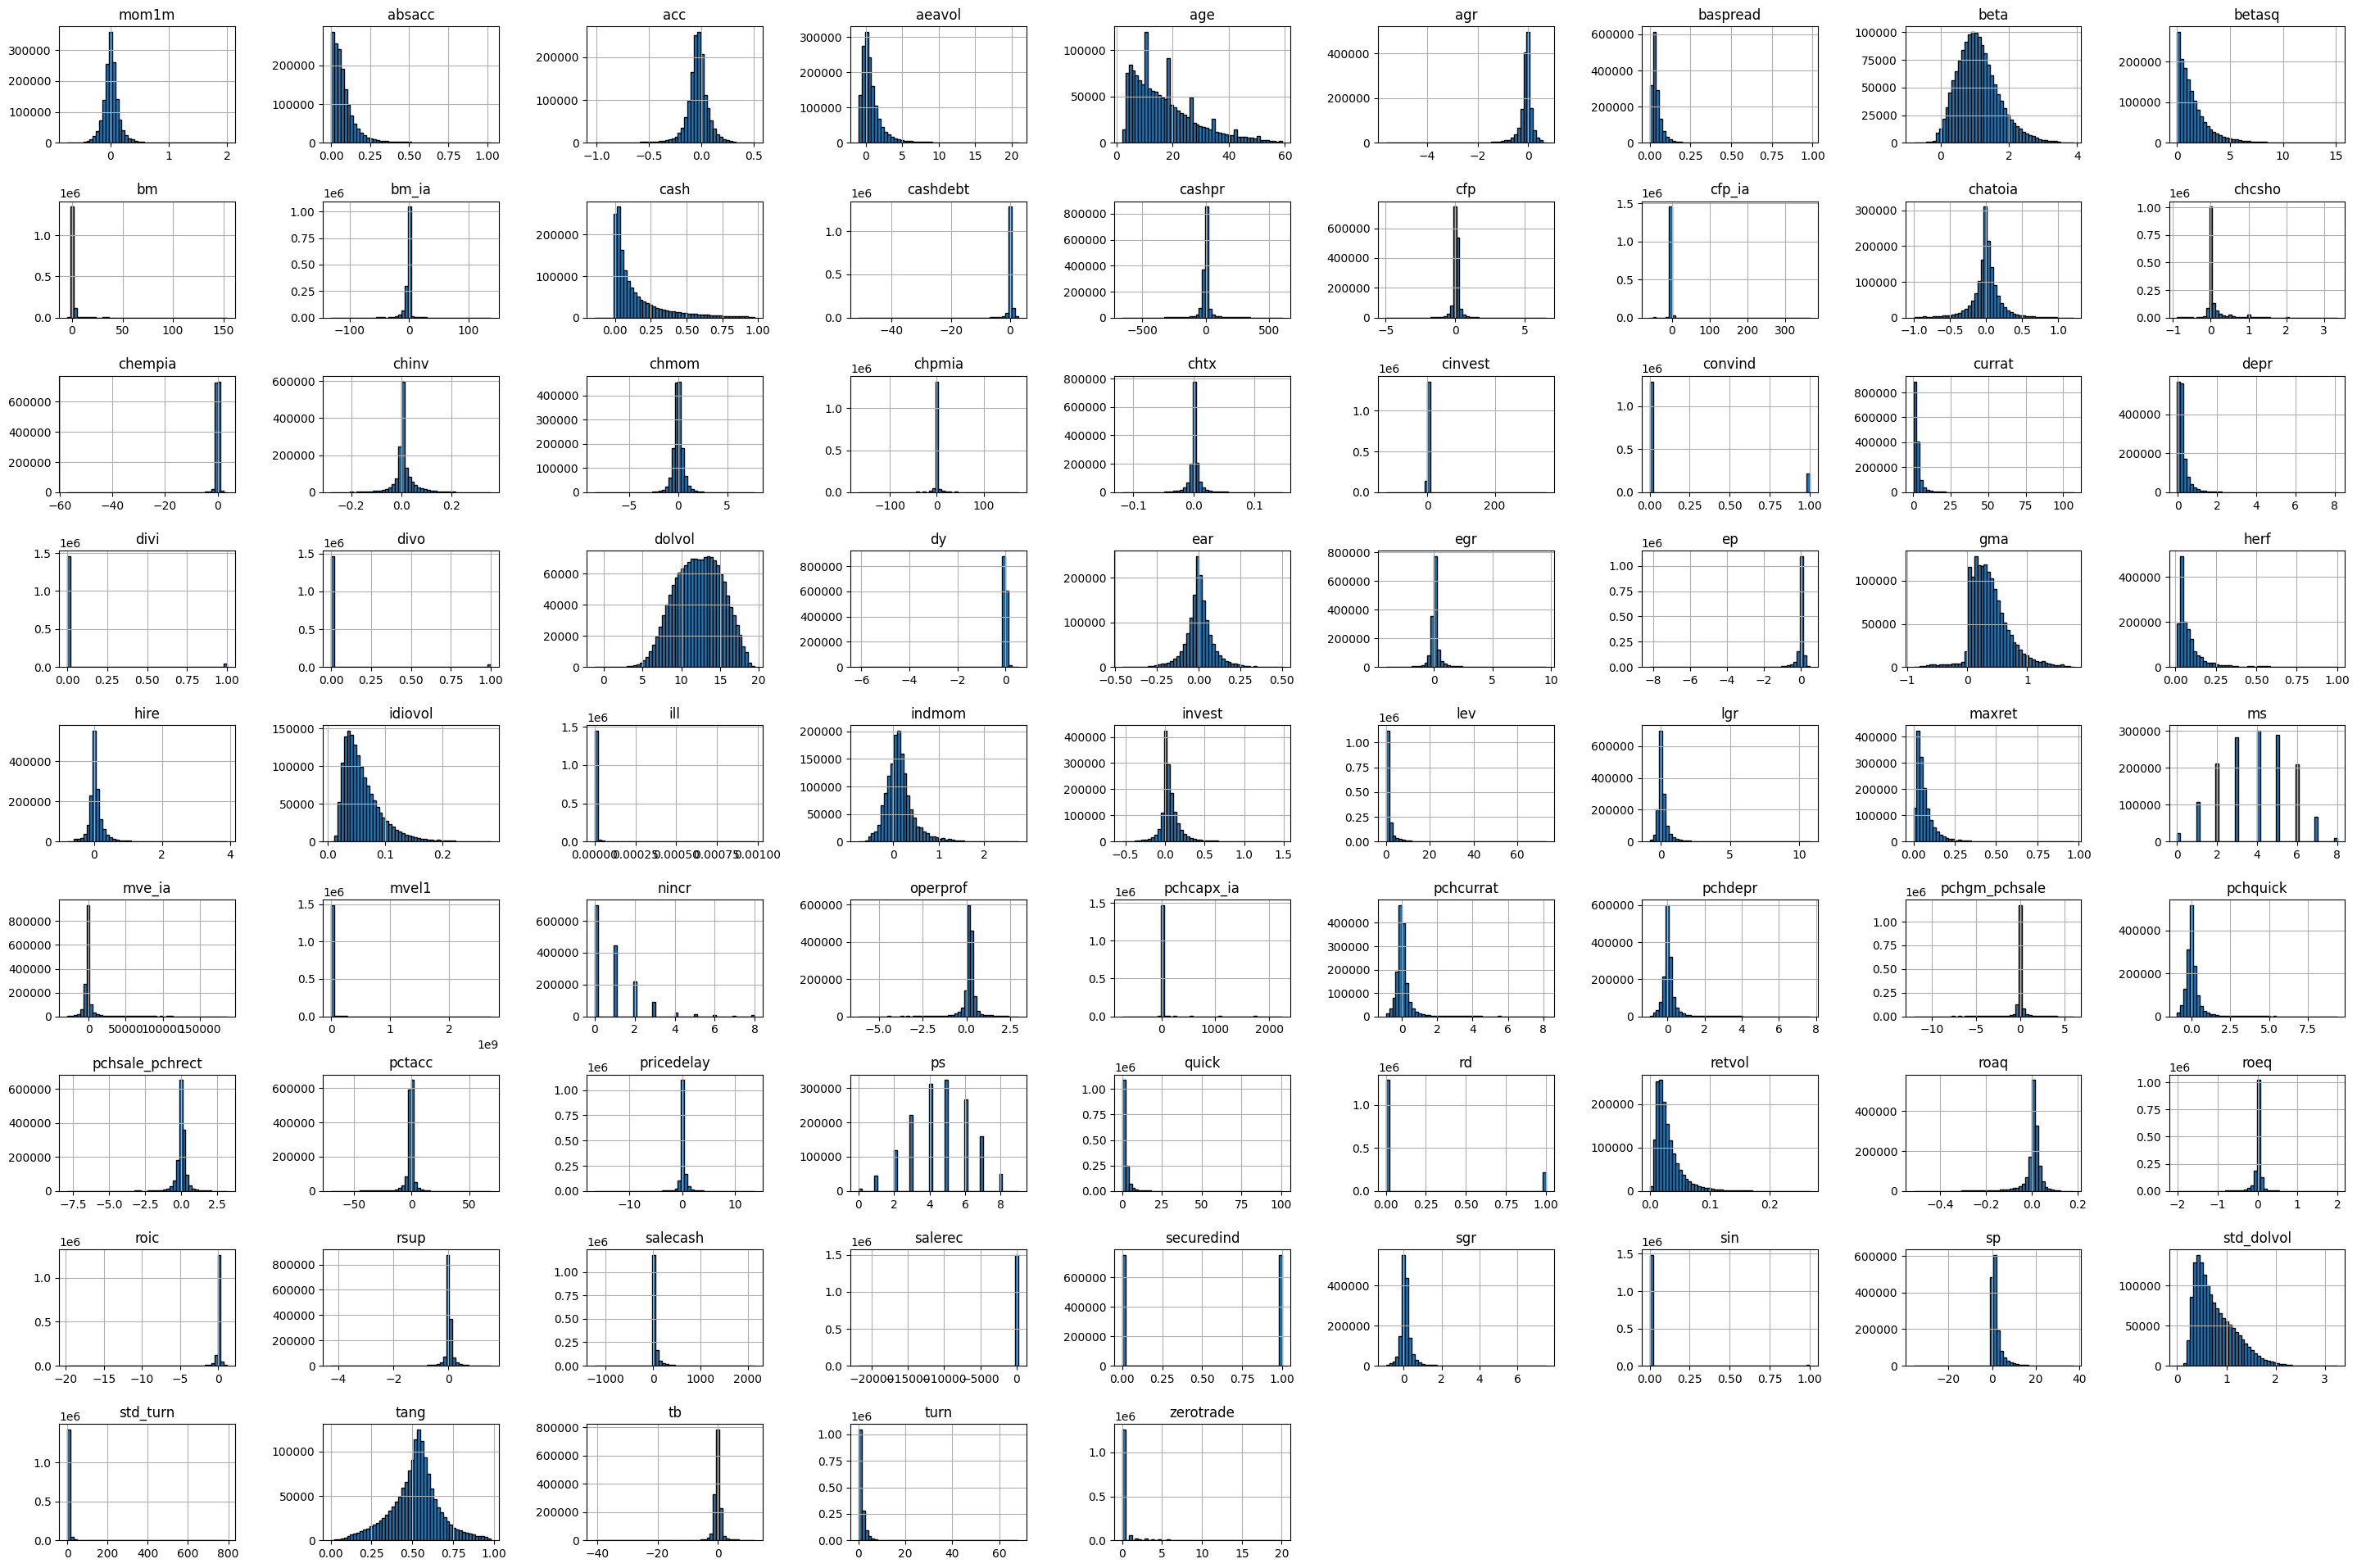

In [300]:
# EDA: Plot histograms for all variables (features + target)
df_with_moms[feature_names_list].hist(figsize=(36, 24), bins=50, edgecolor='black')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

We are looking for similar companies, so by winzdorize or some other treatment of outliers could make more demage than benefit?

In [301]:
#df_with_moms.to_csv('D:/USB Drive/Data/DachengXiu/df_preprocessing_done.csv')